In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def open_img(img_path):
    img = cv2.imread(img_path)
    
    (left, upper, right, lower) = (572, 271, 1330, 940)
    img_cropped = img[upper:lower, left:right]
    
    return img_cropped

In [3]:
def crop_img(img):
    (upper_t, lower_t, left_t, right_t) = (6, 34, 6, 34)
    img = img[upper_t:lower_t, left_t:right_t]
    
    return img

# Histogram methods

In [4]:
def calc_hist(img):
    img = img[upper_t:lower_t, left_t:right_t]
    
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    
#     plt.figure()
    
    hist_arr = []
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
#         plt.title("'Flattened' Color Histogram")
#         plt.xlabel("Bins")
#         plt.ylabel("# of Pixels")
        
        hist = cv2.calcHist([chan], [0], None, [128], [0, 256])
        norm_hist = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        hist_arr.append(norm_hist)
        
        # plot the histogram
#         axes[0].plot(norm_hist, color = color)
#         axes[0].set_xlim([0, 128])
    
#     axes[1].imshow(img[::,::,::-1])
#     plt.show()    
#     plt.close()
    
    return hist_arr

In [5]:
def plot_hist(hist):
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    
    chans = (0, 1, 2)
    colors = ("b", "g", "r")
    for (chan, color) in zip(chans, colors):
        plt.plot(hist[chan], color=color)
    
    plt.show()
    plt.close()

In [6]:
def calc_all_hist():
    hist_all_label = []
    img_all_label = []
    
    labeled_folder_path = "img_gallery"
    labels = [str(i) for i in range(4)]
    label_str = ['BG', 'APPL', 'BODY', 'HEAD']
    n_label = int(labels[-1]) + 1
    
    for label in labels:
        labeled_path = f"{labeled_folder_path}/{label}/"

        hist_label = []        
        img_label = []
        for filename in os.listdir(labeled_path):
#             print(labeled_path + filename)
            img = cv2.imread(labeled_path + filename)
            img_crp = crop_img(img)
            
            hist_img = calc_hist(img_crp)
            hist_label.append(hist_img)
            img_label.append(img_crp)
        hist_all_label.append(hist_label)
        img_all_label.append(img_label)
        
    return hist_all_label, img_all_label

# Preprocessing methods

In [7]:
def preprocessing(img):
    bg = open_img("img_raw/bg.png")
    
    # background subtraction
    img_sub = cv2.subtract(img, bg)
    
    # masking the image with the background
    img_gray = cv2.cvtColor(img_sub, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(img_gray,5,255,cv2.THRESH_BINARY)

    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh1,kernel,iterations = 2)
    dilation = cv2.dilate(erosion,kernel,iterations = 2)
    
    img_masked = cv2.bitwise_and(img, img, mask=dilation)
    
    return img_masked

In [8]:
def separate_img_to_tiles(img, image_no, out_folder):
    nrows = 15
    ncols = 17
    img_tiles = []

    size = 40
    w_start = 35
    h_start = 31

    y_start = h_start
    for i in range(nrows):
        if(i%2==0):
            y_end = y_start + size
        elif(i%2==1):
            y_end = y_start + (size+1)

        img_row = []
        x_start = w_start
        for j in range(ncols):
            if(j%2==0):
                x_end = x_start + (size+1)
            elif(j%2==1):
                x_end = x_start + size
            
            img_i = img[y_start:y_start+size, x_start:x_start+size]
            img_row.append(img_i)
            
            dir_path = f"{out_folder}/img_{image_no}"
            if(not os.path.exists(dir_path)):
                os.mkdir(dir_path)
            
            first_digit = str(i+1)
            second_digit = str(j+1)
            if(i+1<10):
                first_digit = f"0{first_digit}"
            if(j+1<10):
                second_digit = f"0{second_digit}"

            cv2.imwrite(f"{dir_path}/img_{image_no}_{first_digit}_{second_digit}.png", img_i)
            
            # set the rightmost x-coordinate to be the new x_start
            x_start = x_end
            
        # set the bottommost y-coordinate to be the new y_start
        y_start = y_end
        
        img_tiles.append(img_row)
    
    return img_tiles

In [9]:
def segmentation(image_no, in_folder, out_folder):
    img_path = f"{in_folder}/{image_no}.png"
    img1 = open_img(img_path)    
    img1_pp = preprocessing(img1)
    img1_tiles = separate_img_to_tiles(img1_pp, image_no, out_folder)
        
    return img1_tiles

# Prediction method

In [14]:
def predict_img_label(img, hist_all_label, threshold):
    img = crop_img(img)
    hist_img = calc_hist(img)
    
    matched_i = -1
    matched_j = -1
    max_coeff = 0
    
    for i in range(n_label):
        for j in range(len(hist_all_label[i])):
            sum_diff = 0
            diffs = []
            for chan in range(3):
                diff = cv2.compareHist(hist_img[chan], hist_all_label[i][j][chan], cv2.HISTCMP_CORREL)
                sum_diff += diff
                diffs.append(diff)

            avg_diff = sum_diff/3
            to_print = False
            if(avg_diff > threshold):
                to_print = True
                for k in range(3):
                    if(diffs[k]<threshold):
                        to_print = False

            if(to_print):
                if(avg_diff>max_coeff):
                    max_coeff = avg_diff
                    matched_i = i
                    matched_j = j
    
    if(max_coeff!=0):
        return matched_i, matched_j, max_coeff
    
    return 0, -1, 0

# Executions

In [11]:
image_no = 11
bg = open_img("img_raw/bg.png")
img1 = open_img(f"img_raw/{image_no}.png")

bg_gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [13]:
for i in range(1,17):
    segmentation(i, "img_raw", "img_proc")

In [18]:
for i in range(18):
    segmentation(i, "img_probe", "img_probe")

## Demo

In [18]:
labeled_folder_path = "img_gallery"
labels = [str(i) for i in range(4)]
label_str = ['BG', 'APPL', 'BODY', 'HEAD']
n_label = int(labels[-1]) + 1

(upper_t, lower_t, left_t, right_t) = (6, 34, 6, 34)

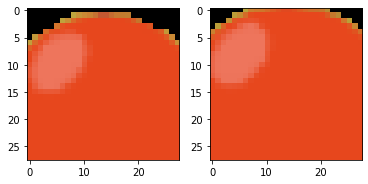

filename = img_0_02_06.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


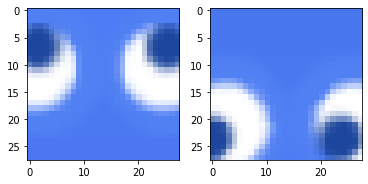

filename = img_0_05_06.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.7187937863298067
----------------------------------------------------------


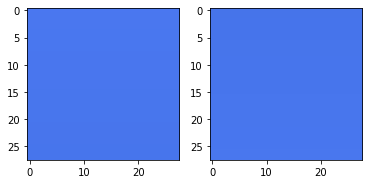

filename = img_0_06_06.png, label = BODY, i = 2, j = 22, Max coeff. = 0.9495105469751725
----------------------------------------------------------


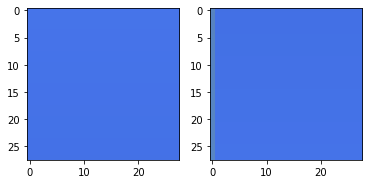

filename = img_0_07_06.png, label = BODY, i = 2, j = 21, Max coeff. = 0.9747910033823944
----------------------------------------------------------


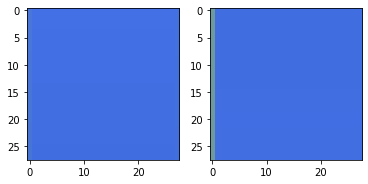

filename = img_0_08_06.png, label = BODY, i = 2, j = 9, Max coeff. = 0.9723521743720189
----------------------------------------------------------


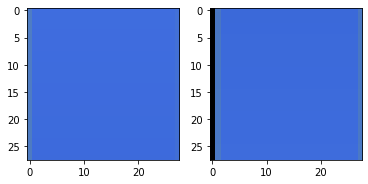

filename = img_0_09_06.png, label = BODY, i = 2, j = 19, Max coeff. = 0.8057160332174188
----------------------------------------------------------


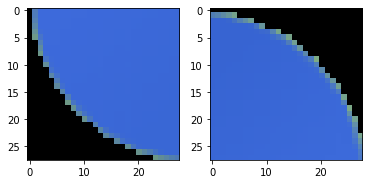

filename = img_0_10_06.png, label = BODY, i = 2, j = 8, Max coeff. = 0.9397093432760876
----------------------------------------------------------


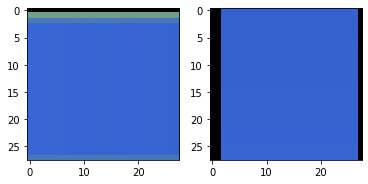

filename = img_0_10_07.png, label = BODY, i = 2, j = 16, Max coeff. = 0.5332415201301568
----------------------------------------------------------


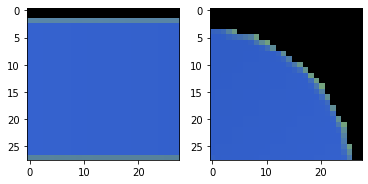

filename = img_0_10_08.png, label = BODY, i = 2, j = 14, Max coeff. = 0.2919581949303501
----------------------------------------------------------


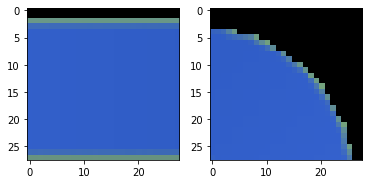

filename = img_0_10_09.png, label = BODY, i = 2, j = 14, Max coeff. = 0.2213996039789691
----------------------------------------------------------


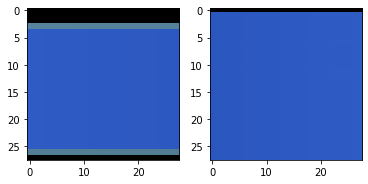

filename = img_0_10_10.png, label = BODY, i = 2, j = 11, Max coeff. = 0.8430689087036752
----------------------------------------------------------


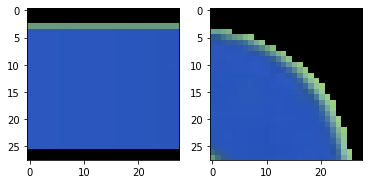

filename = img_0_10_11.png, label = BODY, i = 2, j = 1, Max coeff. = 0.6897659615424149
----------------------------------------------------------


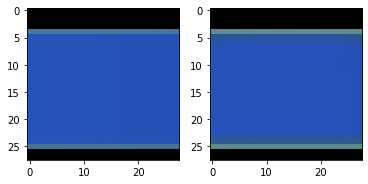

filename = img_0_10_12.png, label = BODY, i = 2, j = 3, Max coeff. = 0.7275349645795058
----------------------------------------------------------


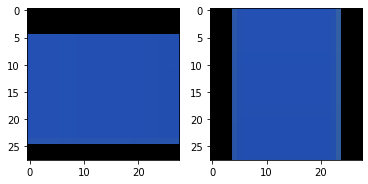

filename = img_0_10_13.png, label = BODY, i = 2, j = 10, Max coeff. = 0.9599490302591724
----------------------------------------------------------


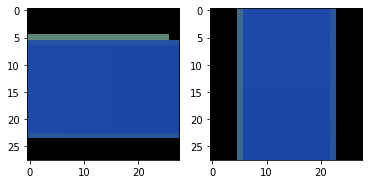

filename = img_0_10_15.png, label = BODY, i = 2, j = 15, Max coeff. = 0.9709226197729374
----------------------------------------------------------


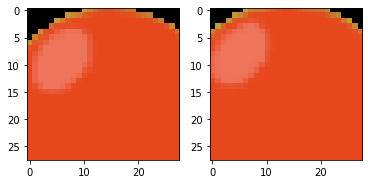

filename = img_1_02_02.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


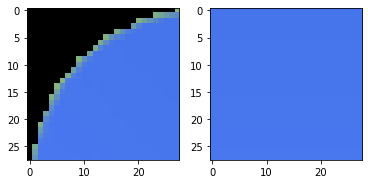

filename = img_1_02_03.png, label = BODY, i = 2, j = 22, Max coeff. = 0.9211217378091915
----------------------------------------------------------


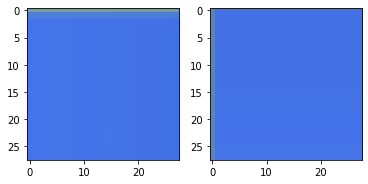

filename = img_1_02_04.png, label = BODY, i = 2, j = 21, Max coeff. = 0.9284905189145342
----------------------------------------------------------


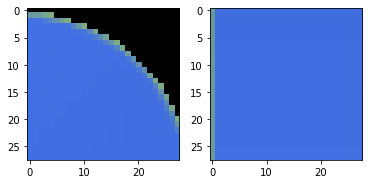

filename = img_1_02_05.png, label = BODY, i = 2, j = 20, Max coeff. = 0.9710950439131062
----------------------------------------------------------


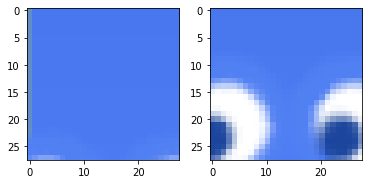

filename = img_1_03_03.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.5266335709498353
----------------------------------------------------------


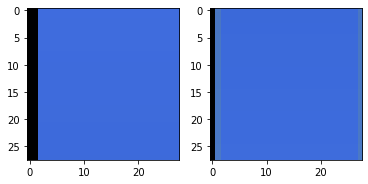

filename = img_1_03_05.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9030967113474514
----------------------------------------------------------


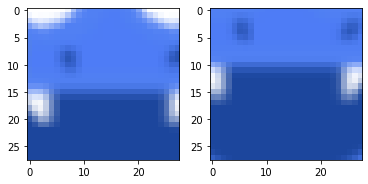

filename = img_1_04_03.png, label = HEAD, i = 3, j = 2, Max coeff. = 0.9782250345389474
----------------------------------------------------------


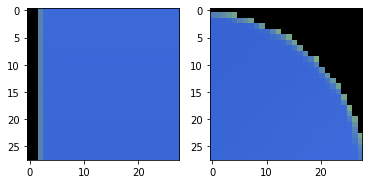

filename = img_1_04_05.png, label = BODY, i = 2, j = 8, Max coeff. = 0.8028118795898301
----------------------------------------------------------


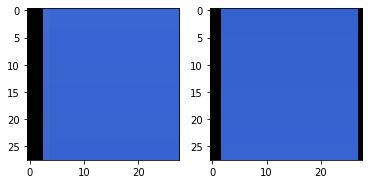

filename = img_1_05_05.png, label = BODY, i = 2, j = 16, Max coeff. = 0.656996465263648
----------------------------------------------------------


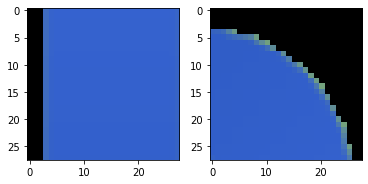

filename = img_1_06_05.png, label = BODY, i = 2, j = 14, Max coeff. = 0.35907462563826376
----------------------------------------------------------


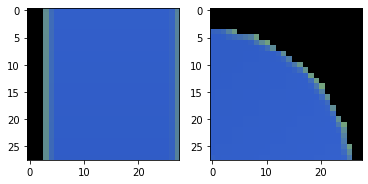

filename = img_1_07_05.png, label = BODY, i = 2, j = 14, Max coeff. = 0.21225408125748343
----------------------------------------------------------


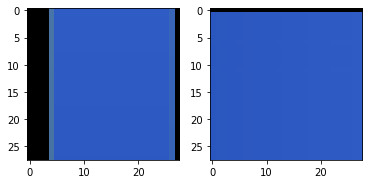

filename = img_1_08_05.png, label = BODY, i = 2, j = 11, Max coeff. = 0.9118976995955063
----------------------------------------------------------


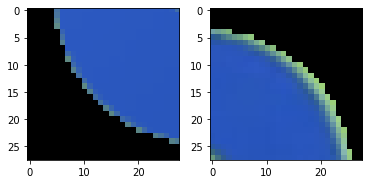

filename = img_1_09_05.png, label = BODY, i = 2, j = 1, Max coeff. = 0.8701339220080948
----------------------------------------------------------


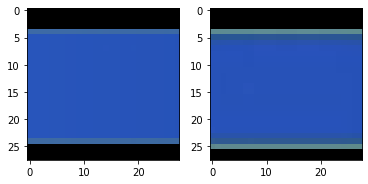

filename = img_1_09_06.png, label = BODY, i = 2, j = 3, Max coeff. = 0.9169837328701546
----------------------------------------------------------


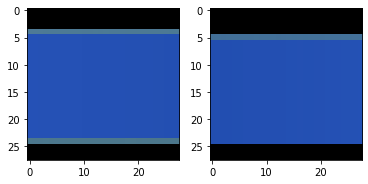

filename = img_1_09_07.png, label = BODY, i = 2, j = 12, Max coeff. = 0.9125960344898467
----------------------------------------------------------


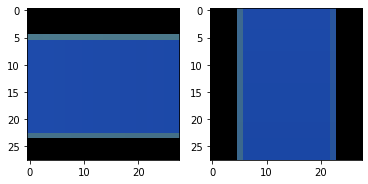

filename = img_1_09_09.png, label = BODY, i = 2, j = 15, Max coeff. = 0.5461179200342711
----------------------------------------------------------


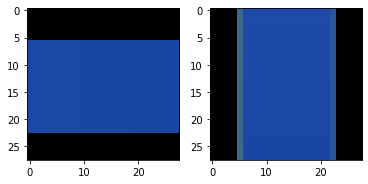

filename = img_1_09_10.png, label = BODY, i = 2, j = 15, Max coeff. = 0.6014700980359741
----------------------------------------------------------


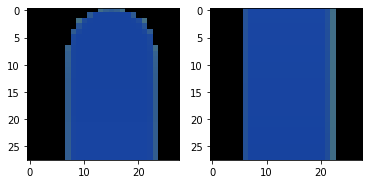

filename = img_2_07_11.png, label = BODY, i = 2, j = 17, Max coeff. = 0.932266294709216
----------------------------------------------------------


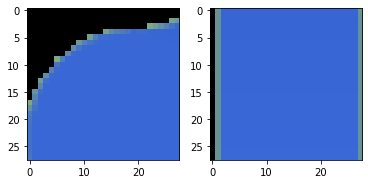

filename = img_2_08_02.png, label = BODY, i = 2, j = 18, Max coeff. = 0.8545238257099802
----------------------------------------------------------


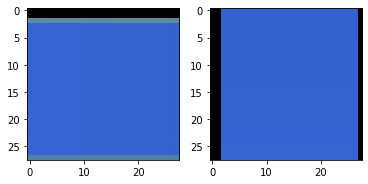

filename = img_2_08_03.png, label = BODY, i = 2, j = 16, Max coeff. = 0.9625427184635971
----------------------------------------------------------


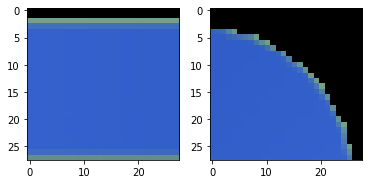

filename = img_2_08_04.png, label = BODY, i = 2, j = 14, Max coeff. = 0.7145839789693292
----------------------------------------------------------


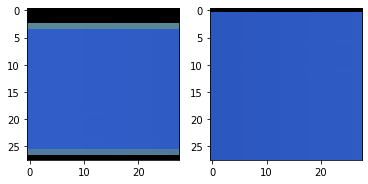

filename = img_2_08_05.png, label = BODY, i = 2, j = 11, Max coeff. = 0.30090088205257515
----------------------------------------------------------


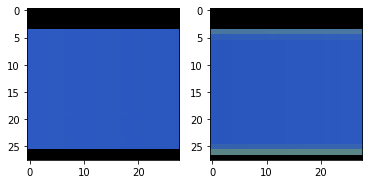

filename = img_2_08_06.png, label = BODY, i = 2, j = 13, Max coeff. = 0.8521523901837561
----------------------------------------------------------


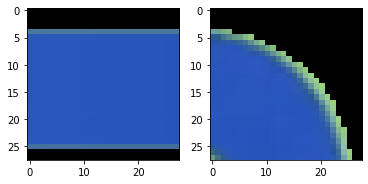

filename = img_2_08_07.png, label = BODY, i = 2, j = 1, Max coeff. = 0.5953891355540364
----------------------------------------------------------


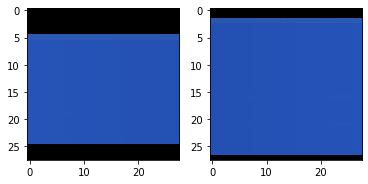

filename = img_2_08_08.png, label = BODY, i = 2, j = 4, Max coeff. = 0.8523637673731713
----------------------------------------------------------


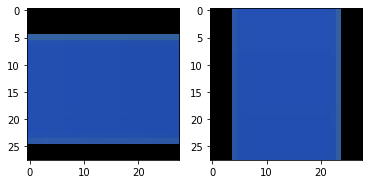

filename = img_2_08_09.png, label = BODY, i = 2, j = 10, Max coeff. = 0.651834274285417
----------------------------------------------------------


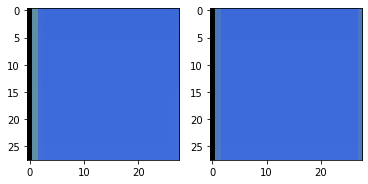

filename = img_2_09_02.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9250445044898084
----------------------------------------------------------


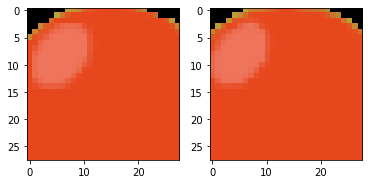

filename = img_2_09_10.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


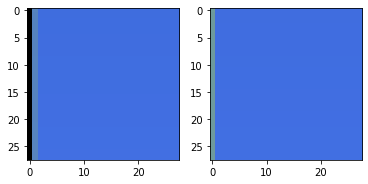

filename = img_2_10_02.png, label = BODY, i = 2, j = 9, Max coeff. = 0.991837036963051
----------------------------------------------------------


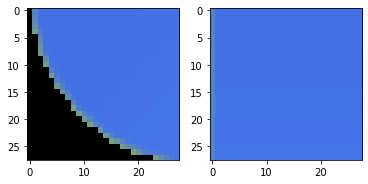

filename = img_2_11_02.png, label = BODY, i = 2, j = 21, Max coeff. = 0.9088275757556863
----------------------------------------------------------


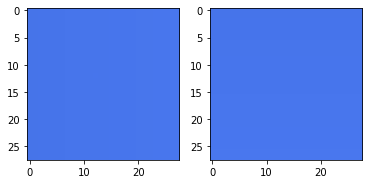

filename = img_2_11_03.png, label = BODY, i = 2, j = 22, Max coeff. = 0.9675853716493487
----------------------------------------------------------


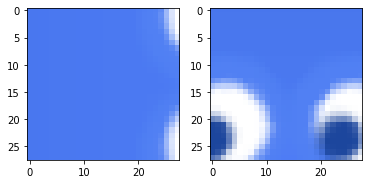

filename = img_2_11_04.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.5761646849893217
----------------------------------------------------------


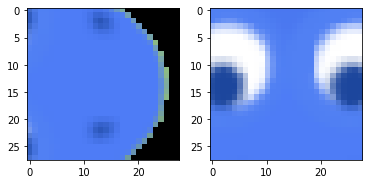

filename = img_2_11_05.png, label = HEAD, i = 3, j = 0, Max coeff. = 0.7533193373733528
----------------------------------------------------------


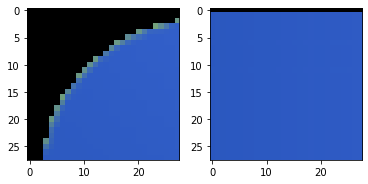

filename = img_3_02_11.png, label = BODY, i = 2, j = 11, Max coeff. = 0.43788644317517106
----------------------------------------------------------


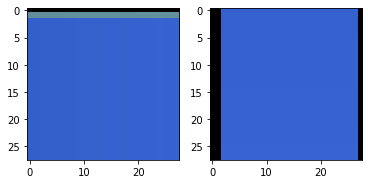

filename = img_3_02_12.png, label = BODY, i = 2, j = 16, Max coeff. = 0.6701446357632346
----------------------------------------------------------


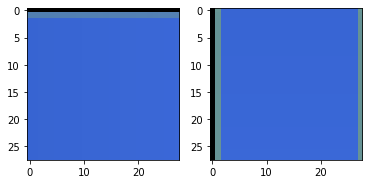

filename = img_3_02_13.png, label = BODY, i = 2, j = 18, Max coeff. = 0.8975979842569585
----------------------------------------------------------


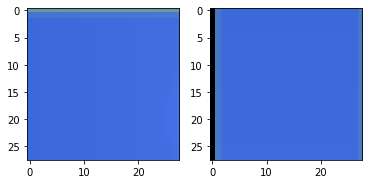

filename = img_3_02_14.png, label = BODY, i = 2, j = 19, Max coeff. = 0.39263550401003894
----------------------------------------------------------


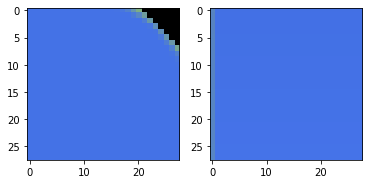

filename = img_3_02_15.png, label = BODY, i = 2, j = 21, Max coeff. = 0.8839664722828952
----------------------------------------------------------


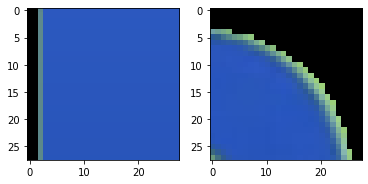

filename = img_3_03_11.png, label = BODY, i = 2, j = 1, Max coeff. = 0.5774170159470811
----------------------------------------------------------


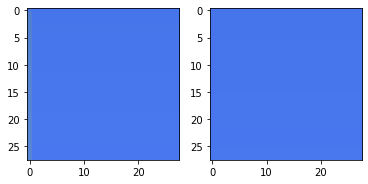

filename = img_3_03_15.png, label = BODY, i = 2, j = 22, Max coeff. = 0.8164523051464193
----------------------------------------------------------


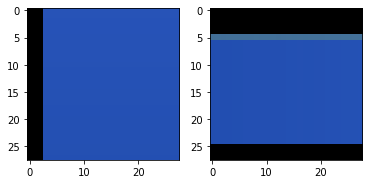

filename = img_3_04_11.png, label = BODY, i = 2, j = 12, Max coeff. = 0.8222038013874166
----------------------------------------------------------


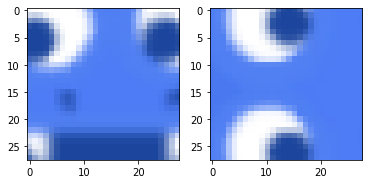

filename = img_3_04_15.png, label = HEAD, i = 3, j = 1, Max coeff. = 0.8819318566832685
----------------------------------------------------------


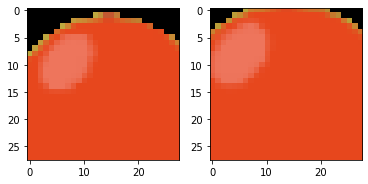

filename = img_3_06_04.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


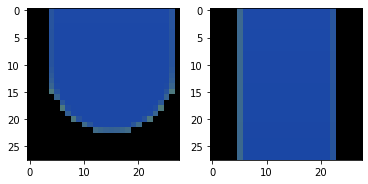

filename = img_3_06_11.png, label = BODY, i = 2, j = 15, Max coeff. = 0.7673140024122006
----------------------------------------------------------


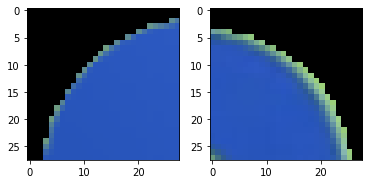

filename = img_4_03_09.png, label = BODY, i = 2, j = 1, Max coeff. = 0.5831025315623372
----------------------------------------------------------


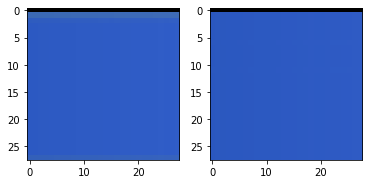

filename = img_4_03_10.png, label = BODY, i = 2, j = 11, Max coeff. = 0.32843622967763825
----------------------------------------------------------


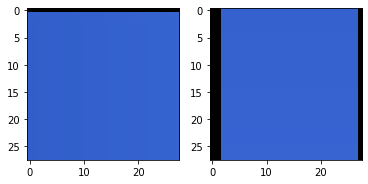

filename = img_4_03_11.png, label = BODY, i = 2, j = 16, Max coeff. = 0.469540045810884
----------------------------------------------------------


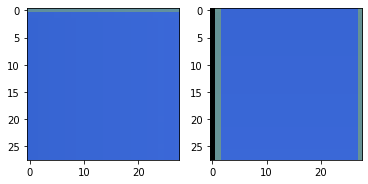

filename = img_4_03_12.png, label = BODY, i = 2, j = 18, Max coeff. = 0.9922584193194984
----------------------------------------------------------


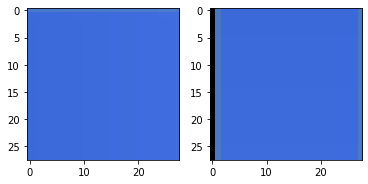

filename = img_4_03_13.png, label = BODY, i = 2, j = 19, Max coeff. = 0.3623625733609812
----------------------------------------------------------


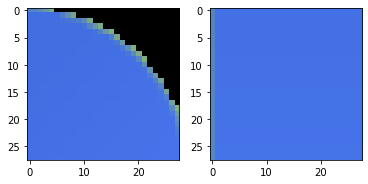

filename = img_4_03_14.png, label = BODY, i = 2, j = 21, Max coeff. = 0.9721331651240167
----------------------------------------------------------


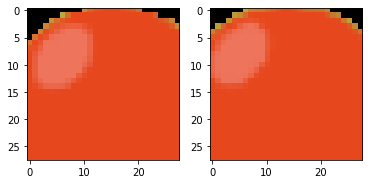

filename = img_4_03_15.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


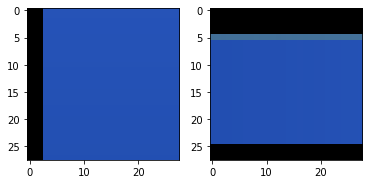

filename = img_4_04_09.png, label = BODY, i = 2, j = 12, Max coeff. = 0.9203179343604426
----------------------------------------------------------


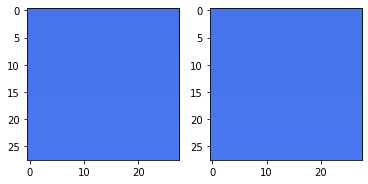

filename = img_4_04_14.png, label = BODY, i = 2, j = 22, Max coeff. = 0.8830112690492508
----------------------------------------------------------


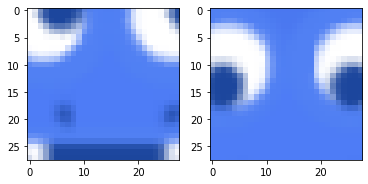

filename = img_4_05_14.png, label = HEAD, i = 3, j = 0, Max coeff. = 0.9442558064373613
----------------------------------------------------------


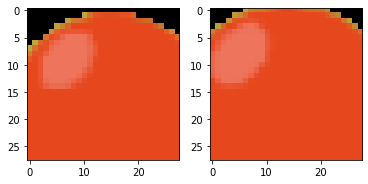

filename = img_5_01_15.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


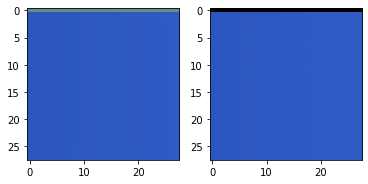

filename = img_5_09_10.png, label = BODY, i = 2, j = 11, Max coeff. = 0.9089958889291081
----------------------------------------------------------


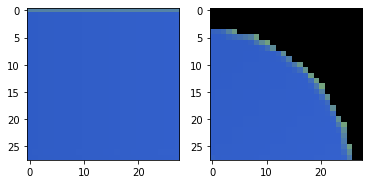

filename = img_5_09_11.png, label = BODY, i = 2, j = 14, Max coeff. = 0.7459188909083689
----------------------------------------------------------


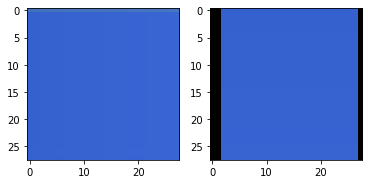

filename = img_5_09_12.png, label = BODY, i = 2, j = 16, Max coeff. = 0.5296933980336399
----------------------------------------------------------


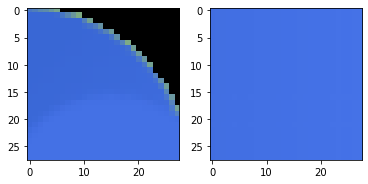

filename = img_5_09_13.png, label = BODY, i = 2, j = 5, Max coeff. = 0.8165674568871149
----------------------------------------------------------


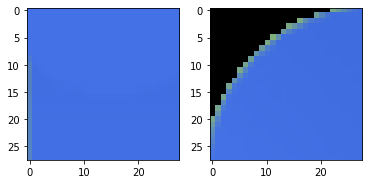

filename = img_5_10_13.png, label = BODY, i = 2, j = 6, Max coeff. = 0.7782062401792027
----------------------------------------------------------


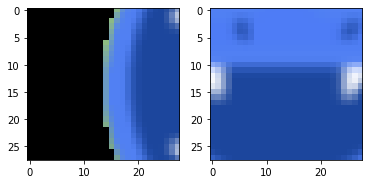

filename = img_5_11_11.png, label = HEAD, i = 3, j = 2, Max coeff. = 0.8854701667235824
----------------------------------------------------------


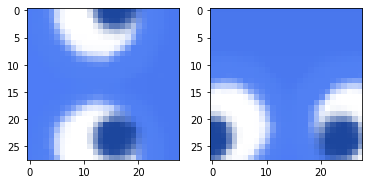

filename = img_5_11_12.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.7090552018748865
----------------------------------------------------------


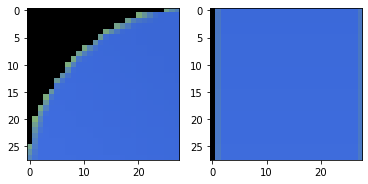

filename = img_6_03_08.png, label = BODY, i = 2, j = 19, Max coeff. = 0.8802865952669782
----------------------------------------------------------


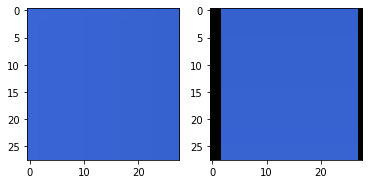

filename = img_6_03_09.png, label = BODY, i = 2, j = 16, Max coeff. = 0.9642029837076431
----------------------------------------------------------


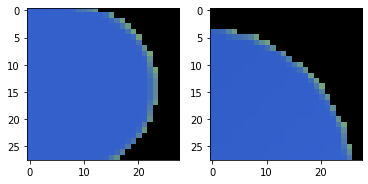

filename = img_6_03_10.png, label = BODY, i = 2, j = 14, Max coeff. = 0.8222744771011873
----------------------------------------------------------


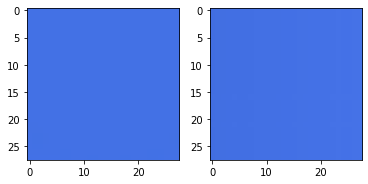

filename = img_6_04_08.png, label = BODY, i = 2, j = 5, Max coeff. = 0.7716015297650993
----------------------------------------------------------


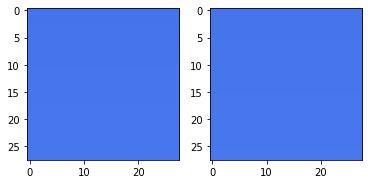

filename = img_6_05_08.png, label = BODY, i = 2, j = 22, Max coeff. = 0.9955425548930007
----------------------------------------------------------


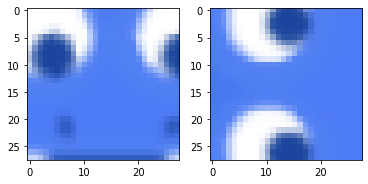

filename = img_6_06_08.png, label = HEAD, i = 3, j = 1, Max coeff. = 0.9457499359696646
----------------------------------------------------------


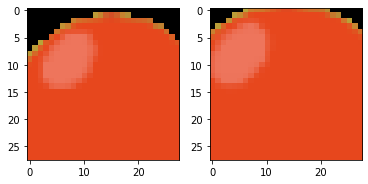

filename = img_6_12_13.png, label = APPL, i = 1, j = 6, Max coeff. = 0.9992086082323003
----------------------------------------------------------


In [19]:
sample_folder_path = "img_probe"
subfolder_path = [f"{sample_folder_path}/img_{i}/" for i in range(7)]

threshold = 0
hist_all_label = []
img_all_label = []
hist_all_label, img_all_label = calc_all_hist()

for path in subfolder_path:
    for filename in os.listdir(path):
        img = cv2.imread(path + filename)
        img = crop_img(img)
        
        img_label, img_no, max_coeff = predict_img_label(img, hist_all_label, threshold)
        
        if(img_label!=-1 and img_label!=0):
            fig, axes = plt.subplots(ncols=2, nrows=1)
            axes[0].imshow(img[::,::,::-1])
            axes[1].imshow(img_all_label[img_label][img_no][::,::,::-1])
            plt.show()
            plt.close()
            print(f"filename = {filename}, label = {label_str[img_label]}, i = {img_label}, j = {img_no}, Max coeff. = {max_coeff}")
            print('----------------------------------------------------------')
    print('========================================================================================')

# Evaluation**

In [32]:
folder_path = "img_probe_labeled"
labels = [str(i) for i in range(4)]
label_str = ['BG', 'APPL', 'BODY', 'HEAD']

threshold = 0
hist_all_label, img_all_label = calc_all_hist()

# array of labels
predicted = []
ground_truth = []

for label in labels:
    probe_folder_path = f"{folder_path}/{label}/"
    for filename in os.listdir(probe_folder_path):
        img = cv2.imread(probe_folder_path + filename)
        img = crop_img(img)
        img_label, img_no, coeff = predict_img_label(img, hist_all_label, threshold)
        
        ground_truth.append(int(label))
        predicted.append(img_label)

## Confusion Matrix

In [33]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [35]:
def show_conf_matrix(y_test, y_pred, labels):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [36]:
def show_clf_report(y_test, y_pred, labels):
    print(classification_report(y_test, y_pred, target_names=labels))

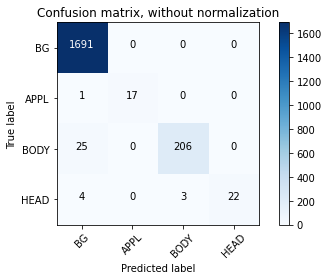

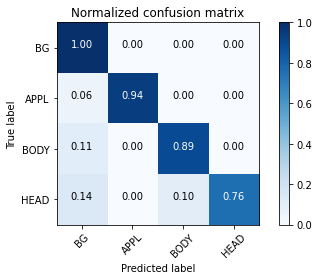

              precision    recall  f1-score   support

          BG       0.98      1.00      0.99      1691
        APPL       1.00      0.94      0.97        18
        BODY       0.99      0.89      0.94       231
        HEAD       1.00      0.76      0.86        29

    accuracy                           0.98      1969
   macro avg       0.99      0.90      0.94      1969
weighted avg       0.98      0.98      0.98      1969



In [37]:
show_conf_matrix(ground_truth, predicted, label_str)
show_clf_report(ground_truth, predicted, label_str)